Today's Topics

- Tokenization
- Lemmatization
- Sentence separation
- Power Law Distributions (http://colala.berkeley.edu/papers/piantadosi2014zipfs.pdf)

# Tokenization

Tokenization is the task of segmenting a string into *tokens*. A token often corresponds to a word (in the context of computational linguistics), though it may correspond to other kinds of strings, such as punctuation. 

Formally, we say that a tokenizer maps a string (in $\Sigma^*$) into a string of strings (in $\Sigma^{**}$).  

$$\text{tokenize}: \Sigma^* \rightarrow \Sigma^{**}$$

We can generally do tokenization reasonably well in English by finding substrings that have white space on either side. We could do this in Python using `str.split()`, though a regular expression will turn out to be more useful.

In [1]:
import re

news = ("Lin Xingzhi said that the trade war prompted the relocation of "
        "factories in China to Vietnam, Laos, India, Taiwan and even Malaysia.")

re.findall("(?:(.*?)(?:\s|$))+?", news)

['Lin',
 'Xingzhi',
 'said',
 'that',
 'the',
 'trade',
 'war',
 'prompted',
 'the',
 'relocation',
 'of',
 'factories',
 'in',
 'China',
 'to',
 'Vietnam,',
 'Laos,',
 'India,',
 'Taiwan',
 'and',
 'even',
 'Malaysia.',
 '']

Note that this implementaton of $\text{tokenize}$ is furthermore invertible:

$$\text{tokenize}^{-1}: \Sigma^{**} \rightarrow \Sigma^*$$

That is, can recover the original string from the tokenized variant, in this case by simply joining all tokens by whitespace. **Not all implementations of $\text{tokenize}$, viewed as functions from strings to strings of strings, are invertible**. 

For instance, note that, even for a short piece of text like this, we're missing certain things we might want to capture:

1. In the case of the name `Lin Xingzhi`, we are probably oversegmenting. Really, we probably want to be a single token. We'll deal with this when we introduce the task of *named entity recognition* (NER).
2. In the case of the list of country names, some country names have punctuation on the end (`Vietnam,`, `Laos,`, `India,`, `Malaysia.`), while others don't (`Taiwan`).

To handle these, we might try to introduce additional tokenization rules by augmenting our regular expression.

In [2]:
# this regular expression won't work for general comma-separated lists
re.findall("(?:([^A-Z].*?|(?:[A-Z].*?(?:\s?))+)(?:,?\s|\.$))+?", news)

['Lin Xingzhi',
 'said',
 'that',
 'the',
 'trade',
 'war',
 'prompted',
 'the',
 'relocation',
 'of',
 'factories',
 'in',
 'China',
 'to',
 'Vietnam',
 'Laos',
 'India',
 'Taiwan',
 'and',
 'even',
 'Malaysia']

This works reasonably well in this case, but we are actually throwing out punctuation, where generally a tokenizer will retain it as its own token. This fact implies that we cannot reconstruct the original string from it's tokenization. And even if we were to augment our tokenizer to retain the punctuation as separate tokens...

In [3]:
# this regular expression won't work for general comma-separated lists
re.findall("(?:((?<=\s)[^A-Z,\.][^,\.]*?|(?:[A-Z][^,\.]*?(?:\s?))+|[,\.])(?=,?\s|\.$))+?", news)

['Lin Xingzhi',
 'said',
 'that',
 'the',
 'trade',
 'war',
 'prompted',
 'the',
 'relocation',
 'of',
 'factories',
 'in',
 'China',
 'to',
 'Vietnam',
 ',',
 'Laos',
 ',',
 'India',
 ',',
 'Taiwan',
 'and',
 'even',
 'Malaysia']

...we wouldn't be able to unambiguously reconstruct the string, because we couldn't be sure whether a whitespace should come before or after a punctuation mark. (We could devise heuristics based on our knowledge of English orthographic conventions to get close, but we couldn't know for sure.)  

Thus, if we want to be able to reconstruct the original string (and we don't necessarily always do), we need to have $\text{tokenize}$ produce additional information in order to reconstruct the original string: usually some form of *character offset*, which tells us the beginning and ending points of a token relative to the beginning of the original string.

$$\text{tokenization-offset}: \Sigma^* \rightarrow (\mathbb{N} \times \mathbb{N})^{*}$$

We could then use $\text{tokenization-offset}$ to produce a tokenization by indexing into the original string. (These offsets either need to cover the entire input string, or we need to know what characters to default to for any spans of the original string, such as white-space characters, we didn't include in the tokenization.)

Ignoring the reconstruction issue, though, we will see that the regular expression above won't work in general. For instance, our current regular expression doesn't handle contractions (`'ll`, `'d`, `n't`, etc.), which we generally want to treat as separate tokens (since they are semantically equivalent to full words: `will`, `would`, `not`, etc.), and it won't handle other kinds of punctuation (e.g. `-`), which could be word-internal or its own token. It also doesn't handle names (and more generally, multiword expressions) that don't fit a very specific format involving title-casing.

These issues get much more difficult when we move outside of English. For instance, consider the following Chinese text from [this article](https://www.post852.com/270084/%E4%B8%AD%E7%92%B0/).

Example from [this post](https://medium.com/@jjsham/nlp-tokenizing-chinese-phases-3302da4336bf).

In [4]:
news = "林行止表示貿易戰促使在中國的工廠搬遷到越南、寮國、印度、台灣甚至是馬來西亞"

Google Translate translates the article as follows:

`Lin Xingzhi said that the trade war prompted the relocation of factories in China to Vietnam, Laos, India, Taiwan and even Malaysia.`

If you didn't know anything about Chinese, the lack of white space here might make you think that it is highly synthetic; but it is the opposite: Chinese is highly analytic. Either way, even the a really fancy regular expression won't work here for.

We could of course try splitting every character apart.

In [5]:
list(news)

['林',
 '行',
 '止',
 '表',
 '示',
 '貿',
 '易',
 '戰',
 '促',
 '使',
 '在',
 '中',
 '國',
 '的',
 '工',
 '廠',
 '搬',
 '遷',
 '到',
 '越',
 '南',
 '、',
 '寮',
 '國',
 '、',
 '印',
 '度',
 '、',
 '台',
 '灣',
 '甚',
 '至',
 '是',
 '馬',
 '來',
 '西',
 '亞']

This doesn't work for reasons similar to English. Just like in English, words in Chinese can be multiple characters long. For instance, `林行止` (Lin Xingzhi) and `馬來西亞` are names (Malaysia). But even worse, most characters can stand on there own as words as well. For instance, `林行止` separated by character would be the nonsense phrase "forest walk halt" and `馬來西亞` separated by character would be "horse come to Western Asia". 

The more general point is that good tokenization requires knowing the context of a token. This is true even in English: consider the string `New York`. In the context of the sentence `I live in Rochester, New York`, we probably want `New York` to be a token. But in the context of `I read the New York Times this morning`, we probably don't: we want `New York Times` instead.

Again, we might be able to devise heuristics for handling this case–like take the maximal string, but it's still not going to handle multiword expressions like `run the gamut`, where we're generally not going to have orthographic conventions like title-casing to help us out: should we tokenize this as `run the gamut` or `run`, `the`, `gamut`?

So what should we do? For the purposes of this course, our answer is going to be "use existing packages"–largely because actually solving the tokenization problem, even in English, turns out to be really hard; and our best systems are ones that require fairly heavy machine learning-based approaches (covered in LING281 and LING282). 

I'll discuss two of the most popular state-of-the-art packages.

- [`stanza`](https://stanfordnlp.github.io/stanza/)
- [`spacy`](https://spacy.io/)

You may have also run across the [`nltk`](https://www.nltk.org/). I strongly advise aginst using `nltk` for any of the text normalization we're going to cover today. The packages I'll discuss are so much better that it's not even worth considering. (`nltk` can still be useful for loading particular kinds of resources like [`wordnet`](https://wordnet.princeton.edu/), and we will use it in Assignmnt 6.)

## Stanza

To use `stanza`, we first need to install it.

In [6]:
!pip install stanza

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 691.3/691.3 KB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 KB 19.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234926 sha256=92ab931ca7b6e3c2f89dc32e8d1907220968bc40261a58ccaf817f158cb44c06
  Stored in directory: /root/.cache/pip/wheels/86/62/9e/a6b27a681abcde69970dbc0326ff51955f3beac72f15696984
Successfully built emoji


### Downloading Models

We then need to download the relevant language-specific models.

In [7]:
import stanza

# Download an English model
stanza.download('en')
  
# Similarly, download a (traditional) Chinese model
stanza.download('zh')

INFO:stanza:Downloading default packages for language: en (English) ...


INFO:stanza:Finished downloading models and saved to /root/stanza_resources.


INFO:stanza:"zh" is an alias for "zh-hans"
INFO:stanza:Downloading default packages for language: zh-hans (Simplified_Chinese) ...


INFO:stanza:Finished downloading models and saved to /root/stanza_resources.


#### Processing Text - setting up a pipeline in stanza
 (Source: https://bit.ly/2kb8eJU)

 - To process a piece of text, you'll need to first construct a `Pipeline` with different `Processor` units. The pipeline is language-specific, so again you'll need to first specify the language.

 - By default, the pipeline will include all processors, including tokenization, multi-word token expansion, part-of-speech tagging, lemmatization and dependency parsing. However, you can always specify what processors you want to include with the processors argument.

 - Note that the backend device has to be specified when building the pipeline. By default, the pipeline will always use a CUDA-compatible GPU if it exists on your device to accelerate computing, and it'll fall back to CPU if no such GPU can be found. You can force the pipeline to use CPU regardless by setting use_gpu=False.

In [8]:
# Build an English pipeline, with all processors by default
stanza_en_nlp = stanza.Pipeline(lang='en', processors = 'tokenize', use_gpu=False)

# Build a Chinese pipeline, with customized processor list, and force it to use CPU
stanza_zh_nlp = stanza.Pipeline(lang='zh', processors='tokenize', use_gpu=False)

### A full processors list looks like: processors='tokenize,lemma,pos,depparse'

INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |

INFO:stanza:Use device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Done loading processors!
INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:"zh" is an alias for "zh-hans"
INFO:stanza:Loading these models for language: zh-hans (Simplified_Chinese):
| Processor | Package |
-----------------------
| tokenize  | gsdsimp |

INFO:stanza:Use device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Done loading processors!


#### Creating document objects

In [9]:
en_str = "Homelessness is to be found in the large numbers of mentally ill and substance-abusing people in the homeless population, don't you think?"
zh_str = "林行止表示貿易戰促使在中國的工廠搬遷到越南、寮國、印度、台灣甚至是馬來西亞"

In [10]:
## Our earlier algo using regex function
import re
print(re.findall('[^ ]+', en_str))  ## based on whitespace seperation

['Homelessness', 'is', 'to', 'be', 'found', 'in', 'the', 'large', 'numbers', 'of', 'mentally', 'ill', 'and', 'substance-abusing', 'people', 'in', 'the', 'homeless', 'population,', "don't", 'you', 'think?']


In [11]:
# Processing English text
en_doc = stanza_en_nlp(en_str)
print(type(en_doc))

# Processing Chinese text
zh_doc = stanza_zh_nlp(zh_str)
print(type(zh_doc))

<class 'stanza.models.common.doc.Document'>
<class 'stanza.models.common.doc.Document'>


In [12]:
for sent in en_doc.sentences:
    stanza_en_sent = [word.text for word in sent.words]
    print(stanza_en_sent)

['Homelessness', 'is', 'to', 'be', 'found', 'in', 'the', 'large', 'numbers', 'of', 'mentally', 'ill', 'and', 'substance', '-', 'abusing', 'people', 'in', 'the', 'homeless', 'population', ',', 'do', "n't", 'you', 'think', '?']


In [13]:
for i, sent in enumerate(zh_doc.sentences):
    stanza_zh_sent = [word.text for word in sent.words]
    print(stanza_zh_sent)

['林', '行止', '表示', '貿易', '戰', '促使', '在', '中國', '的', '工廠', '搬遷', '到', '越南', '、', '寮國', '、', '印度', '、', '台灣', '甚至是', '馬', '來西', '亞']


## Spacy

To use `spacy`, we similarly need to install it.

In [14]:
!pip install spacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


And we need to download its [language-specific models](https://spacy.io/usage/models).

In [15]:
import spacy

!python -m spacy download en_core_web_sm
!python -m spacy download zh_core_web_sm
!python -m spacy download it_core_news_sm

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2023-02-06 17:17:12.352179: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 40.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2023-02-06 17:17:29.485403: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━

 We then need to load the models.

In [16]:
spacy_en_nlp = spacy.load("en_core_web_sm") #disable=["tagger", "parser", "ner"]
spacy_zh_nlp = spacy.load("zh_core_web_sm") #disable=["tagger", "parser", "ner"]

#### Creating document objects

In [17]:
en_doc = spacy_en_nlp(en_str)
spacy_en_sent = [w.text for w in en_doc]
print(spacy_en_sent)

['Homelessness', 'is', 'to', 'be', 'found', 'in', 'the', 'large', 'numbers', 'of', 'mentally', 'ill', 'and', 'substance', '-', 'abusing', 'people', 'in', 'the', 'homeless', 'population', ',', 'do', "n't", 'you', 'think', '?']


In [18]:
zh_doc = spacy_en_nlp(zh_str)
spacy_zh_sent = [w.text for w in zh_doc]
print(spacy_zh_sent)

['林行止表示貿易戰促使在中國的工廠搬遷到越南、寮國、印度、台灣甚至是馬來西亞']


## Sentence Separation

When working with actually text, that text won't come with clear sentence boundaries. So in addition to tokenization, you usually want to do sentence separation. 

When working with standard English orthography, you can usually look at cues such as periods, question marks, exclamation points, etc. to tell you when a sentence ends.  

In [19]:
en_str_canonical = "The fictional Pandoran biosphere, from James Cameron's Avatar, teems with a biodiversity of bioluminescent species ranging from hexapodal animals to other types of exotic fauna and flora. The Pandoran ecology forms a vast neural network spanning the entire lunar surface into which the Na'vi and other creatures can connect. The strength of this collective consciousness is illustrated when the human invaders are defeated in battle by the Pandoran ecology, after the Na'vi were nearly defeated. Cameron utilized a team of expert advisors in order to make the various examples of fauna and flora as scientifically feasible as possible."

Text from other sources (e.g. twitter or reddit) can be significantly more difficult to correctly sentence separate, depending on the conventions of the community, and you sometimes need a model specific to that source. 

#### Stanza

In [20]:
# Processing English text
en_doc = stanza_en_nlp(en_str_canonical)

for sent in en_doc.sentences:
   print(' '.join([w.text for w in sent.words]))

The fictional Pandoran biosphere , from James Cameron 's Avatar , teems with a biodiversity of bioluminescent species ranging from hexapodal animals to other types of exotic fauna and flora .
The Pandoran ecology forms a vast neural network spanning the entire lunar surface into which the Na'vi and other creatures can connect .
The strength of this collective consciousness is illustrated when the human invaders are defeated in battle by the Pandoran ecology , after the Na'vi were nearly defeated .
Cameron utilized a team of expert advisors in order to make the various examples of fauna and flora as scientifically feasible as possible .


#### Spacy

In [21]:
for sent in en_doc.sentences:
   print(' '.join([w.text for w in sent.words]))

The fictional Pandoran biosphere , from James Cameron 's Avatar , teems with a biodiversity of bioluminescent species ranging from hexapodal animals to other types of exotic fauna and flora .
The Pandoran ecology forms a vast neural network spanning the entire lunar surface into which the Na'vi and other creatures can connect .
The strength of this collective consciousness is illustrated when the human invaders are defeated in battle by the Pandoran ecology , after the Na'vi were nearly defeated .
Cameron utilized a team of expert advisors in order to make the various examples of fauna and flora as scientifically feasible as possible .


## Lemmatization

Lemmatization is the task of determining a canonicalized form of some token. When these tokens are words, we often say that a lemmatizer determines that word's *root form*. For instance, The words `am`, `are`, and `is` have the same root form (or *lemma*) `be`; and the words `dinner` and `dinners` both have the lemma `dinner`. Formally, we might model lemmatiztion as a function from strings (\Sigma^*) to some subset of those strings that we will call the roots ($R$). 

$$\text{lemmatize}: \Sigma^* \rightarrow R \subset \Sigma^*$$

In general, lemmatization is assumed to only strip inflectional morphology from a word. For instance, `derivations` would be lemmatized to `derivation` rather than `derive`, since `ation` is a derivational morpheme, which we can see from the fact that it changes the words grammatical ctegory from verb to noun.   

Lemmatization is definitionally a destructive procedure. If we want to retain the morphological structure of a word, we would need to do *morphological analysis*. Usually, morphological analysis is assumed to tokenize a string into a subset of strings of strings that we will call the morphemes ($M$); and usually we assume that these morphemes include both inflectional and derivational morphemes.

$$\text{analyze-morphology}: $\Sigma^* \rightarrow M^* \subset \Sigma^{**}$$

Constructing a *morphological analyzer* (especially when we want the analyzer to handle derivational morphology correctly) is a much harder problem than constructing a lemmatizer, and there are far fewer off-the-shelf sytems for doing it. In LING281/481 and LING282/482, I cover how to build such a system.

To get the lemmatized forms of words, we need to modify the processors list in the corenlp object.

In [22]:
# Build an English pipeline, with all processors by default
stanza_en_nlp = stanza.Pipeline(lang='en', processors = 'tokenize,lemma', use_gpu=False)

# Build a Chinese pipeline, with customized processor list, and force it to use CPU
stanza_zh_nlp = stanza.Pipeline(lang='zh', processors='tokenize,lemma', use_gpu=False)

### A full processors list looks like: processors='tokenize,lemma,pos,depparse'

INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| lemma     | combined |

INFO:stanza:Use device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: lemma
INFO:stanza:Done loading processors!
INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:"zh" is an alias for "zh-hans"
INFO:stanza:Loading these models for language: zh-hans (Simplified_Chinese):
| Processor | Package |
-----------------------
| tokenize  | gsdsimp |
| lemma     | gsdsimp |

INFO:stanza:Use device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: lemma
INFO:stanza:Done loading processors!


In [23]:
# Processing English text
en_doc = stanza_en_nlp(en_str)
print(type(en_doc))

# Processing Chinese text
zh_doc = stanza_zh_nlp(zh_str)
print(type(zh_doc))

<class 'stanza.models.common.doc.Document'>
<class 'stanza.models.common.doc.Document'>


In [24]:
for sent in en_doc.sentences:
    stanza_en_sent = [(word.text, word.lemma) for word in sent.words]
    print(stanza_en_sent)

[('Homelessness', 'homelessness'), ('is', 'be'), ('to', 'to'), ('be', 'be'), ('found', 'find'), ('in', 'in'), ('the', 'the'), ('large', 'large'), ('numbers', 'number'), ('of', 'of'), ('mentally', 'mentally'), ('ill', 'ill'), ('and', 'and'), ('substance', 'substance'), ('-', '-'), ('abusing', 'abuse'), ('people', 'people'), ('in', 'in'), ('the', 'the'), ('homeless', 'homeless'), ('population', 'population'), (',', ','), ('do', 'do'), ("n't", 'not'), ('you', 'you'), ('think', 'think'), ('?', '?')]


In [25]:
for i, sent in enumerate(zh_doc.sentences):
    stanza_zh_sent = [(word.text, word.lemma) for word in sent.words]
    print(stanza_zh_sent)

[('林', '林'), ('行止', '行止'), ('表示', '表示'), ('貿易', '貿易'), ('戰', '戰'), ('促使', '促使'), ('在', '在'), ('中國', '中國'), ('的', '的'), ('工廠', '工廠'), ('搬遷', '搬遷'), ('到', '到'), ('越南', '越南'), ('、', '、'), ('寮國', '寮國'), ('、', '、'), ('印度', '印度'), ('、', '、'), ('台灣', '台灣'), ('甚至是', '甚至是'), ('馬', '馬'), ('來西', '來西'), ('亞', '亞')]


#### Spacy

In [26]:
en_str = "I don't like him."
en_doc = spacy_en_nlp(en_str)
spacy_en_sent = [(w.text, w.lemma_) for w in en_doc]
print(spacy_en_sent)

[('I', 'I'), ('do', 'do'), ("n't", 'not'), ('like', 'like'), ('him', 'he'), ('.', '.')]


## Named Entity Recognition

Vanilla tokenization algorithms don't always handle multi-word expressions (MWEs) well—e.g. idioms like "kick the bucket" or names. Names are somewhat easier than idioms for various reasons. 

We can use the spacy package to extract entities from a text string as follows:

In [27]:
en_str = '''
This is an example string. Harry Potter is a name of an individual. Ron Weasley and Draco Malfoy are his school-mates.
Voldemort is another individual who has an army of Death Eaters.
He belongs to the Hogwart school. Nobody actually know if the school actually exists. But, nevertheless, people love the concept.
Do you think the NER-System, Spacy, will capture all the named entities in this string correctly? The New York Times certainly does.
'''

en_doc = spacy_en_nlp(en_str)
en_doc.ents

(Harry Potter,
 Ron Weasley,
 Draco Malfoy,
 Voldemort,
 Death Eaters,
 NER-System,
 The New York Times)

As we can see above, the NER system is pretty good at finding the named entities in a text

# Bonus: Power Law Distributions

When working with text, it is important to know about some of it's distributional characteristics: in particular, that words tend to be power law distributed.

## Reading Corpora

We will talk in depth about writing corpus readers (especially for annotated text) in the next submodule, but to demonstrate what a power law distribution is, we can use `nltk` to quickly pull up a few classic (small) text corpora.

In [28]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


The [Brown Corpus](https://en.wikipedia.org/wiki/Brown_Corpus) was the first major multi-genre corpus. It is extremely small by modern standards: ~1 million words. For comparison, most modern NLP systems are trained on billions of words of text. But even with this smallish size, we can see useful distributional properties.

In [29]:
import nltk

nltk.download('brown')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

In [30]:
from nltk.corpus import brown ## Importing brown corpus

In [52]:
print("Total number of words in the Brown corpus: {:,}".format(len(brown.words())))

Total number of words in the Brown corpus: 1,161,192


## Frequency counts

Let's count the frequency of each word in the corpus

In [32]:
from collections import defaultdict, Counter

In [33]:
count_dct = defaultdict(int)

for word in brown.words():
    count_dct[word] += 1
  
print("Vocabulary size of Brown corpus: {:,}".format(len(count_dct)))

Vocabulary size of Brown corpus: 56,057


In [34]:
k_object = Counter(count_dct)
type(k_object)

collections.Counter

Finding the most frequent n words in the corpus 

In [35]:
k_object.most_common(15)

[('the', 62713),
 (',', 58334),
 ('.', 49346),
 ('of', 36080),
 ('and', 27915),
 ('to', 25732),
 ('a', 21881),
 ('in', 19536),
 ('that', 10237),
 ('is', 10011),
 ('was', 9777),
 ('for', 8841),
 ('``', 8837),
 ("''", 8789),
 ('The', 7258)]

#### Store ranks and frequency of words:

In [55]:
count_dct = defaultdict(int)

for word in brown.words():
  count_dct[word]+=1
  
print("Total number of words in the Brown corpus {:,}".format(len(brown.words())))
print("Vocabulary size of Brown corpus: {:,}".format(len(count_dct)))

word_counts = Counter(count_dct)

Total number of words in the Brown corpus 1,161,192
Vocabulary size of Brown corpus: 56,057


In [56]:
word_counts.most_common(10)

[('the', 62713),
 (',', 58334),
 ('.', 49346),
 ('of', 36080),
 ('and', 27915),
 ('to', 25732),
 ('a', 21881),
 ('in', 19536),
 ('that', 10237),
 ('is', 10011)]

In [38]:
x_axis = []
y_axis = []
words = []

import math

for idx, (word, freq) in enumerate(word_counts.most_common()):
  x_axis.append(math.log(idx+1))
  y_axis.append(math.log(freq))
  words.append(word)

In [39]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Frequency Vs. Rank Distribution (Brown)')

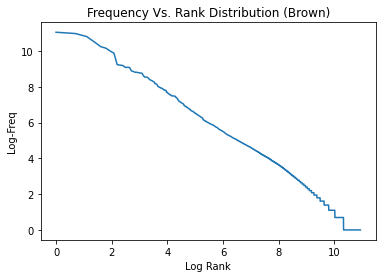

In [40]:
plt.plot(x_axis, y_axis)
plt.xlabel("Log Rank")
plt.ylabel("Log-Freq")
plt.title("Frequency Vs. Rank Distribution (Brown)")

In [41]:
def plot_freq_rank(corpus_words):
  '''
  Input: corpus_words: a list of all the words in the corpus
  
  
  Output: Rank vs Frequency Plot
  '''
  
  count_dct = defaultdict(int)

  for word in corpus_words:
    count_dct[word]+=1

  print("# Words: {:,}, Vocab size: {:,}".format(len(corpus_words),len(count_dct)))
  
  k = Counter(count_dct)
  
  ## Plotting stuff
  x_axis = []
  y_axis = []
  words = []

  import math
  import matplotlib.pyplot as plt

  for idx, (word, freq) in enumerate(k.most_common()):
    x_axis.append(math.log(idx+1))  ## idx+1 because idx starts at 0 and log(0) is undefined
    y_axis.append(math.log(freq))
    words.append(word)
  
  plt.plot(x_axis, y_axis)
  plt.xlabel("Ranks")
  plt.ylabel("Log-Freq")
  plt.title("Frequency Vs. Rank Distribution")

#### Plot unigram graphs for different corpura

In [42]:
nltk.download('gutenberg')
nltk.download('reuters')

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data]   Package reuters is already up-to-date!


True

In [43]:
reuters_words =  nltk.corpus.reuters.words()
shakesp_words =  nltk.corpus.gutenberg.words('shakespeare-caesar.txt')

# Words: 1,720,901, Vocab size: 41,600


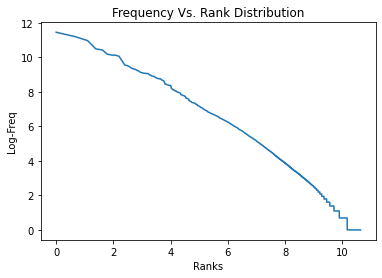

In [44]:
plot_freq_rank(reuters_words)

# Words: 25,833, Vocab size: 3,560


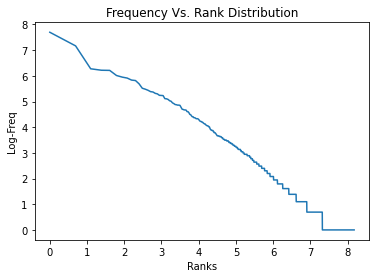

In [45]:
plot_freq_rank(shakesp_words)

## Downloading a Book from Gutenberg (https://www.gutenberg.org)

In [46]:
!wget "https://www.gutenberg.org/files/834/834-0.txt" -O 'sherlock.txt'

--2023-02-06 17:18:33--  https://www.gutenberg.org/files/834/834-0.txt
Resolving www.gutenberg.org (www.gutenberg.org)... 152.19.134.47, 2610:28:3090:3000:0:bad:cafe:47
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 612701 (598K) [text/plain]
Saving to: ‘sherlock.txt’

sherlock.txt        100%[===================>] 598.34K  --.-KB/s    in 0.1s    

2023-02-06 17:18:41 (5.06 MB/s) - ‘sherlock.txt’ saved [612701/612701]



In [47]:
with open('sherlock.txt', 'r') as f:
  sherlock_text = f.read()

In [48]:
sherlock_text[:100]

'\ufeffThe Project Gutenberg eBook of The Memoirs of Sherlock Holmes, by Arthur Conan Doyle\n\nThis eBook is'

In [49]:
sherlock_doc = stanza_en_nlp(sherlock_text)

In [50]:
print("Total number of sentences: {}".format(len(sherlock_doc.sentences)))

sherlock_words = [word.text for sent in sherlock_doc.sentences for word in sent.words]

Total number of sentences: 5948


# Words: 119,247, Vocab size: 8,411


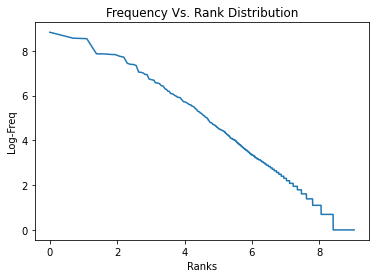

In [51]:
plot_freq_rank(sherlock_words)